In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as data_reader
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [3]:
company = "FB"

start = dt.datetime(2012,1,1)
end = dt.datetime(2020,1,1)

data = data_reader.DataReader(company, 'yahoo', start, end)

data.head()
#data.info()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-05-18,45.000000,38.000000,42.049999,38.230000,573576400,38.230000
2012-05-21,36.660000,33.000000,36.529999,34.029999,168192700,34.029999
2012-05-22,33.590000,30.940001,32.610001,31.000000,101786600,31.000000
2012-05-23,32.500000,31.360001,31.370001,32.000000,73600000,32.000000
2012-05-24,33.209999,31.770000,32.950001,33.029999,50237200,33.029999


In [4]:
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

print (scaled_data)

[[0.10261801]
 [0.08159383]
 [0.06642639]
 ...
 [0.95294592]
 [0.93447466]
 [0.93867948]]


In [5]:
prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days:x, 0])
  y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print(x_train.shape)

(1857, 60, 1)


In [6]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
#prediction of the next closing value
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
59/59 [==============================] - 11s 88ms/step - loss: 0.0690
Epoch 2/25
59/59 [==============================] - 5s 92ms/step - loss: 0.0049
Epoch 3/25
59/59 [==============================] - 5s 93ms/step - loss: 0.0041
Epoch 4/25
59/59 [==============================] - 5s 92ms/step - loss: 0.0045
Epoch 5/25
59/59 [==============================] - 5s 92ms/step - loss: 0.0034
Epoch 6/25
59/59 [==============================] - 6s 93ms/step - loss: 0.0028
Epoch 7/25
59/59 [==============================] - 6s 94ms/step - loss: 0.0032
Epoch 8/25
59/59 [==============================] - 5s 92ms/step - loss: 0.0031
Epoch 9/25
59/59 [==============================] - 6s 94ms/step - loss: 0.0027
Epoch 10/25
59/59 [==============================] - 6s 94ms/step - loss: 0.0037
Epoch 11/25
59/59 [==============================] - 5s 92ms/step - loss: 0.0026
Epoch 12/25
59/59 [==============================] - 6s 93ms/step - loss: 0.0028
Epoch 13/25
59/59 [=================

In [15]:
#Load test data

test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = data_reader.DataReader(company, "yahoo", test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) -len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

# Make predictions on test Data

x_test = []

for x in range(prediction_days, len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)


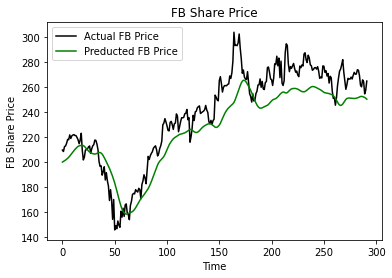

In [16]:
# Plot the test predictions

plt.plot(actual_prices, color="black", label=f"Actual {company} Price")
plt.plot(predicted_prices, color="green", label=f"Preducted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{company} Share Price")
plt.legend()
plt.show()

In [18]:
# Predict Next Days

real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

Prediction: [[249.74225]]
